CPU activated.
CPU activated.
Setting up the environment.
Number of assets: 10
Signals per asset: 6
Training the agent.
Beginning initial training.
out of offline training
 necessary alpha or retrain 0.00039298647070795667
Retraining
Day 2680 p/m ratio: 1.01
Retraining
Retraining
Day 2700 p/m ratio: 1.01
Retraining
Retraining
Retraining
Retraining
Day 2720 p/m ratio: 0.96
Retraining
Day 2740 p/m ratio: 0.99
Retraining
Retraining
Retraining
Day 2760 p/m ratio: 0.96
Retraining
Retraining
Day 2780 p/m ratio: 0.95
Retraining
Retraining
Retraining
Day 2800 p/m ratio: 0.97
Retraining
Retraining
Day 2820 p/m ratio: 0.95
Retraining
Retraining
Retraining
Day 2840 p/m ratio: 0.94
Retraining
Retraining
Retraining
Day 2860 p/m ratio: 0.95
Retraining
Day 2880 p/m ratio: 0.97
Retraining
Retraining
Retraining
Day 2900 p/m ratio: 0.97
Retraining
Retraining
Retraining
Retraining
Day 2920 p/m ratio: 0.96
-0.04 annualized alpha.
22.45 minutes of training.
6421.29 training objective.
Training Time:  22.4 

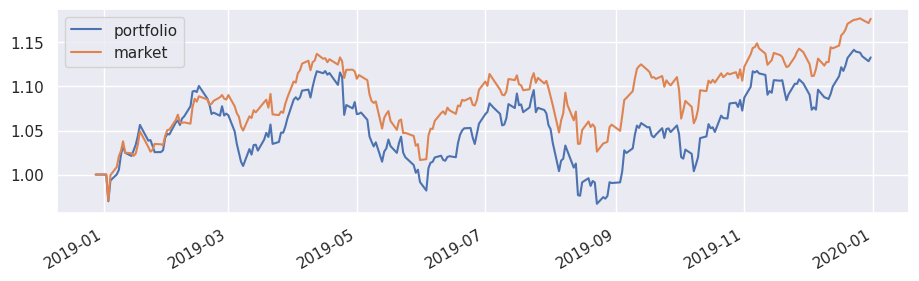

In [5]:
# env.py

import os
import numpy as np
import pandas as pd

EPS = 1e-8


class PortfolioEnv:
    """ This class creates the financial market environment that the Agent interact with.

    The observations include a history of the signals with the given `window_length` ending at the current date.

    Args:
        trading_cost (float):  Cost of trade as a fraction.
        window_length (int):  How many past observations to return.
        prices_name (str):  CSV file name for the price history.
        signals_name (str):  CSV file name for the signals.

    Attributes:
        dates (np.array of np.datetime64):  [n_days] Dates for the signals and price history arrays.
        n_signals (int):  Number of signals for each asset in each observation.
        n_signals_total (int):  Number of total signals in each observation.
        n_assets (int):  Number of assets in the price history.
        market_value (float):  The market value, starting at $1.
        portfolio_value (float):  The portfolio value, starting with $1 in cash.
        gain (np.array):  [n_days, n_assets] The relative price vector; tomorrow's / today's price.
        signals (np.array):  [1, n_signals_total, n_days]  Signals that define the observable environment.
        start_day (int):  The start date index in the signals and price arrays.
        step_number (int):  The step number of the episode.
        asset_names (list of str):  The stock tickers.
        trading_cost (float):  Cost of trade as a fraction.
        window_length (int):  How many past observations to return.
        weights (np.array):  [1 + n_assets]  The portfolio asset weighting starting with cash.
    """

    def __init__(self, trading_cost, window_length, prices_name, signals_name):
        """An environment for financial portfolio management."""

        # Initialize some local parameters
        self.market_value = 1.0
        self.portfolio_value = 1.0
        self.step_number = 0
        self.start_day = 0

        # Save some arguments as attributes
        self.trading_cost = trading_cost
        self.window_length = window_length

        # Read the stock data and convert to the relative price vector (gain)
        #   Note the raw prices have an extra day vs the signals to calculate gain

          #changed for colab
        #src_folder = os.path.split(os.path.dirname(__file__))[0]
        #raw_prices = pd.read_csv(os.path.join(src_folder, prices_name), index_col=0, parse_dates=True)
        raw_prices = pd.read_csv(prices_name, index_col=0, parse_dates=True)
        self.asset_names = raw_prices.columns.tolist()
        self.gain = np.hstack((np.ones((raw_prices.shape[0]-1, 1)), raw_prices.values[1:] / raw_prices.values[:-1]))
        self.dates = raw_prices.index.values
        self.n_dates = self.dates.shape[0] - 1
        self.n_assets = len(self.asset_names)
        self.weights = np.insert(np.zeros(self.n_assets), 0, 1.0)

        # Read the signals

          #changed for colab
        #df = pd.read_csv(os.path.join(src_folder, signals_name), index_col=0, parse_dates=True)
        df = pd.read_csv(signals_name, index_col=0, parse_dates=True)

        signal_names = [s.split("_", 1)[0] for s in df.columns if s.endswith('_' + self.asset_names[0])]
        columns = [s + '_' + a for s in signal_names for a in self.asset_names]
        self.signals = df.loc[:, columns].T.values[np.newaxis, :, :]
        self.n_signals = len(signal_names)
        self.n_signals_total = self.signals.shape[1]



          #Trial 1: Create numpy array to store each step and weights
        #steps_weights_arr = np.array([])
        #self.steps_weights_arr = np.array([])
        #self.add_steps_weights_arr = np.array([])
    # -----------------------------------------------------------------------------------
    def step(self, action):
        """Step the environment.

        Args:
            action (np.array):  The desired portfolio weights [w0...].

        Returns:
            np.array:  [batch_size, n_signals_total, window_length] The observation of the environment (state).
            float:  The reward received from the previous action.
        """

        t = self.start_day + self.step_number  # t is when you make the trade
        w0 = self.weights                      # w0 is the portfolio weights before trading
        p0 = self.portfolio_value              # p0 is the portfolio value before trading
        gain = self.gain[t]                    # gain is the relative price vector; tomorrow's / today's price.

        # Force the new weights (w1) to (0.0, 1.0) and sum weights = 1, note 1st weight is cash
        #   w0_post is the desired portfolio weighting after the trades but still at time t
        w0_post = np.clip(action, a_min=0, a_max=1)
        w0_post = np.insert(w0_post, 0, np.clip(1 - w0_post.sum(), a_min=0, a_max=1))
        w0_post = w0_post / w0_post.sum()

        # Calculate the loss due to trading costs
        loss = p0 * self.trading_cost * (np.abs(w0_post - w0)).sum()

        # Calculate the weights after the price evolution, w1 is the weights at t + 1
        w1 = (gain * w0_post) / (np.dot(gain, w0_post) + EPS)

        # Calculate the portfolio value at t + 1
        p1 = p0 * np.dot(gain, w0_post) - loss
        p1 = np.clip(p1, 0, np.inf)                         # Limit portfolio to zero (busted)
        reward = np.log((p1 + EPS) / (p0 + EPS))            # log rate of return

        # Save weights and portfolio value for next iteration
        self.weights = w1
        self.portfolio_value = p1

        # Observe the new environment (state)
        t0 = t - self.window_length + 1
        state = self.signals[:, :, t0:t+1]

        # Save market value and increment the step number
        self.market_value *= gain.mean()
        self.step_number += 1

        #Trial 1: append t and weights
        #with np.printoptions(precision=3, suppress=False):
          #self.add_steps_weights_arr = np.array([np.append(t,w1)])
          #self.steps_weights_arr = np.append(self.steps_weights_arr, self.add_steps_weights_arr, axis=0)

        #print(f'added {add_steps_weights_arr}')

        return state, reward

    def reset(self, epoch_start, market_value=1.0, portfolio_value=1.0, weights=None):
        """Reset the environment to the initial state.

        Args:
            epoch_start (int):  The epoch start date index.
            market_value (float):  The market value.
            portfolio_value (float):  The portfolio value.
            weights (np.array):  [1 + n_assets]  The portfolio asset weighting starting with cash.

        Returns:
            np.array:  [n_signals_total * window_length] The first state observation
        """
          #Trail 1: print to view when the weights are reset
        #print('env reset')
        self.start_day = epoch_start
        if weights is None:
            self.weights = np.insert(np.zeros(self.n_assets), 0, 1.0)
          #Trail 1: print when weights are reset
            #print(f'weights reset {self.weights}')
            #with np.printoptions(precision=3, suppress=False):
              #self.add_steps_weights_arr = np.array([np.append(self.start_day, self.weights)])
              #self.steps_weights_arr = self.add_steps_weights_arr
              #print(f'reset array{self.steps_weights_arr}')
        else:
            self.weights = weights
        self.market_value = market_value
        self.portfolio_value = portfolio_value
        self.step_number = 0

        t = self.start_day + self.step_number
        t0 = t - self.window_length + 1
        state = self.signals[:, :, t0:t+1]

        return state

#-----------------------------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------------------------
# model.py

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as nn_f

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return -lim, lim


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, n_signals, window_length, n_assets, seed, fc1, fc2):
        """Initialize parameters and build model.

        Args:
            n_signals (int): Number of signals per asset
            window_length (int): Number of days in sliding window
            n_assets (int): Number of assets in portfolio not counting cash
            seed (int): Random seed
            fc1 (int):  Size of 1st hidden layer
            fc2 (int):  Size of 2nd hidden layer
        """

        super(Actor, self).__init__()

        self.n_signals = n_signals

        # TODO: This need to be removed per issue #3
        self.a1 = AssetModel(n_signals, window_length, seed, fc1, fc2)
        self.a2 = AssetModel(n_signals, window_length, seed, fc1, fc2)
        self.a3 = AssetModel(n_signals, window_length, seed, fc1, fc2)
        self.a4 = AssetModel(n_signals, window_length, seed, fc1, fc2)
        self.a5 = AssetModel(n_signals, window_length, seed, fc1, fc2)
        self.a6 = AssetModel(n_signals, window_length, seed, fc1, fc2)
        self.a7 = AssetModel(n_signals, window_length, seed, fc1, fc2)
        self.a8 = AssetModel(n_signals, window_length, seed, fc1, fc2)
        self.a9 = AssetModel(n_signals, window_length, seed, fc1, fc2)
        self.a10 = AssetModel(n_signals, window_length, seed, fc1, fc2)

        if fc2 == 0:
            self.fc_out = nn.Linear(fc1 * n_assets, n_assets)
        else:
            self.fc_out = nn.Linear(fc2 * n_assets, n_assets)
        self.reset_parameters()

        #print(f'this is assetModel a1 for actor: {self.a1}')

    def reset_parameters(self):

        # TODO: This need to be removed per issue #3
        self.a1.reset_parameters()
        self.a2.reset_parameters()
        self.a3.reset_parameters()
        self.a4.reset_parameters()
        self.a5.reset_parameters()
        self.a6.reset_parameters()
        self.a7.reset_parameters()
        self.a8.reset_parameters()
        self.a9.reset_parameters()
        self.a10.reset_parameters()

        self.fc_out.weight.data.uniform_(-3e-3, 3e-3)
        self.fc_out.bias.data.fill_(0.1)

    def forward(self, state):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""

        # TODO: This need to be removed per issue #3
        s1, s2, s3, s4, s5, s6, s7, s8, s9, s10 = torch.split(state, self.n_signals, 1)
        x1 = self.a1(s1)
        x2 = self.a2(s2)
        x3 = self.a3(s3)
        x4 = self.a4(s4)
        x5 = self.a5(s5)
        x6 = self.a6(s6)
        x7 = self.a7(s7)
        x8 = self.a8(s8)
        x9 = self.a9(s9)
        x10 = self.a10(s10)

        x = torch.cat((x1, x2, x3, x4, x5, x6, x7, x8, x9, x10), 1)

        return self.fc_out(x)


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, n_signals, window_length, n_assets, seed, fc1, fc2):
        """Initialize parameters and build model.

        Args:
            n_signals (int): Number of signals per asset
            window_length (int): Number of days in sliding window
            n_assets (int): Number of assets in portfolio not counting cash
            seed (int): Random seed
            fc1 (int):  Size of 1st hidden layer
            fc2 (int):  Size of 2nd hidden layer
        """

        super(Critic, self).__init__()
        self.n_signals = n_signals

        # TODO: This need to be removed per issue #3
        if n_assets != 10:
            print("ERROR:  Only operational to 10 assets per issue #3.")
            raise RuntimeError
        self.a1 = AssetModel(n_signals, window_length, seed, fc1, fc2)
        self.a2 = AssetModel(n_signals, window_length, seed, fc1, fc2)
        self.a3 = AssetModel(n_signals, window_length, seed, fc1, fc2)
        self.a4 = AssetModel(n_signals, window_length, seed, fc1, fc2)
        self.a5 = AssetModel(n_signals, window_length, seed, fc1, fc2)
        self.a6 = AssetModel(n_signals, window_length, seed, fc1, fc2)
        self.a7 = AssetModel(n_signals, window_length, seed, fc1, fc2)
        self.a8 = AssetModel(n_signals, window_length, seed, fc1, fc2)
        self.a9 = AssetModel(n_signals, window_length, seed, fc1, fc2)
        self.a10 = AssetModel(n_signals, window_length, seed, fc1, fc2)

        if fc2 == 0:
            self.fc_out = nn.Linear(fc1 * n_assets + n_assets, n_assets)
        else:
            self.fc_out = nn.Linear(fc2 * n_assets + n_assets, n_assets)
        self.reset_parameters()

        #print(f'this is assetModel a1 for critic: {self.a1}')

    def reset_parameters(self):

        # TODO: This need to be removed per issue #3
        self.a1.reset_parameters()
        self.a2.reset_parameters()
        self.a3.reset_parameters()
        self.a4.reset_parameters()
        self.a5.reset_parameters()
        self.a6.reset_parameters()
        self.a7.reset_parameters()
        self.a8.reset_parameters()
        self.a9.reset_parameters()
        self.a10.reset_parameters()

        self.fc_out.weight.data.uniform_(-3e-3, 3e-3)
        self.fc_out.bias.data.fill_(0.1)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""

        # TODO: This need to be removed per issue #3
        s1, s2, s3, s4, s5, s6, s7, s8, s9, s10 = torch.split(state, self.n_signals, 1)
        x1 = self.a1(s1)
        x2 = self.a2(s2)
        x3 = self.a3(s3)
        x4 = self.a4(s4)
        x5 = self.a5(s5)
        x6 = self.a6(s6)
        x7 = self.a7(s7)
        x8 = self.a8(s8)
        x9 = self.a9(s9)
        x10 = self.a10(s10)

        x = torch.cat((x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, action), 1)

        return self.fc_out(x)


class AssetModel(nn.Module):
    def __init__(self, n_signals, window_length, seed, fc1, fc2):
        """Network built for each asset.

        Args:
            n_signals (int): Number of signals per asset
            window_length (int): Number of days in sliding window
            seed (int): Random seed
            fc1 (int):  Size of 1st hidden layer
            fc2 (int):  Size of 2nd hidden layer
        """
        super(AssetModel, self).__init__()
        out_channels = n_signals
        kernel_size = 3
        self.use_fc2 = fc2 > 0
        self.n_signals = n_signals
        self.conv1d_out = (window_length - kernel_size + 1) * out_channels
        self.seed = torch.manual_seed(seed)

        self.relu = nn.ReLU(inplace=True)
        self.drop1 = nn.Dropout(p=0.1)
        self.drop2 = nn.Dropout(p=0.2)

        self.conv1d = nn.Conv1d(n_signals, out_channels, kernel_size=kernel_size)
        self.bn = nn.BatchNorm1d(out_channels)

        self.fc1 = nn.Linear(self.conv1d_out, fc1)
        if self.use_fc2:
            self.fc2 = nn.Linear(fc1, fc2)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.conv1d.weight)
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc1.bias.data.fill_(0.1)
        if self.use_fc2:
            self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
            self.fc2.bias.data.fill_(0.1)

    def forward(self, state):
        # x = self.relu(self.bn(self.conv1d(state)))
        # x = self.drop1(self.relu(self.bn(self.conv1d(state))))
        # x = self.drop1(self.relu(self.conv1d(state)))
        x = self.relu(self.conv1d(state))
        x = x.contiguous().view(-1, self.conv1d_out)
        # x = self.drop2(self.relu(self.fc1(x)))
        x = self.relu(self.fc1(x))
        if self.use_fc2:
            x = self.drop2(self.relu(self.fc2(x)))
        return x

#-----------------------------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------------------------
# ddpg_agent.py

import numpy as np
import random
import copy
from collections import namedtuple, deque
#from drl.model import Actor, Critic
import torch
import torch.nn.functional as nn_f
import torch.optim as optimum

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Agent:
    """Interacts with and learns from the environment."""

    def __init__(self, n_signals, window_length, n_assets, random_seed, lr_actor, lr_critic, buffer_size,
                 batch_size, tau, gamma, sigma, theta, fc1, fc2):
        """Initialize an Agent object.

        Args:
            n_signals (int): Number of signals per asset
            window_length (int): Number of days in sliding window
            n_assets (int): Number of assets in portfolio not counting cash
            random_seed (int): random seed
            lr_actor (float): initial learning rate for actor
            lr_critic (float): initial learning rate for critic
            batch_size (int): mini batch size
            buffer_size (int): replay buffer size
            gamma (float): discount factor
            tau (float): soft update of target parameters
            sigma (float): OU Noise standard deviation
            theta (float): OU Noise theta gain
            fc1 (int):  Size of 1st hidden layer
            fc2 (int):  Size of 2nd hidden layer
        """
        self.n_signals = n_signals
        self.n_assets = n_assets
        self.seed = random.seed(random_seed)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(n_signals, window_length, n_assets, random_seed, fc1, fc2).to(device)
        self.actor_target = Actor(n_signals, window_length, n_assets, random_seed, fc1, fc2).to(device)
        self.actor_optimizer = optimum.Adam(self.actor_local.parameters(), lr=lr_actor)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(n_signals, window_length, n_assets, random_seed, fc1, fc2).to(device)
        self.critic_target = Critic(n_signals, window_length, n_assets, random_seed, fc1, fc2).to(device)
        self.critic_optimizer = optimum.Adam(self.critic_local.parameters(), lr=lr_critic)

        # Noise process
        self.noise = OUNoise(size=n_assets, seed=random_seed, sigma=sigma, theta=theta)

        # Replay memory
        self.memory = ReplayBuffer(n_assets, buffer_size, batch_size, random_seed)

    def step(self, state, actions, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, actions, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences)

    def act(self, state):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()
        self.actor_local.reset_parameters()
        self.actor_target.reset_parameters()
        self.critic_local.reset_parameters()
        self.critic_target.reset_parameters()

    def learn(self, experiences):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Args:
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
        """
        states, actions, rewards, next_states, done_values = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        q_targets = rewards + (self.gamma * q_targets_next * (1 - done_values))
        # Compute critic loss
        q_expected = self.critic_local(states, actions)
        critic_loss = nn_f.mse_loss(q_expected, q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, self.tau)
        self.soft_update(self.actor_local, self.actor_target, self.tau)

    @staticmethod
    def soft_update(local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)


class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, sigma, theta, mu=0.):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.state = copy.copy(self.mu)

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for _ in range(len(x))])
        self.state = x + dx
        return self.state


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, n_assets, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.n_assets = n_assets
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)

        next_states = np.vstack([e.next_state for e in experiences if e is not None])
        next_states = torch.from_numpy(next_states).float().to(device)

        done_values = np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)
        done_values = torch.from_numpy(done_values).float().to(device)

        return states, actions, rewards, next_states, done_values

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

#-----------------------------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------------------------
# train.py
import ast
import argparse
from collections import deque
import numpy as np
import os
import pandas as pd
import platform
#from drl.ddpg_agent import Agent
#from drl.env import PortfolioEnv
from time import time
import torch

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU activated.")
else:
    device = torch.device("cpu")
    print("CPU activated.")


# ***************************************************************************************
def make_plot(output_dir, start_day, show=False):
    """Makes a pretty training plot call score.png.

    Args:
        output_dir (str):  Location to save output.
        start_day (int):  Date index when trading began.
        show (bool):  If True, show the image.  If False, save the image.
    """

    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set()

    # Load the trading history
    # ---------------------------------------------------------------------------------------
    #history = pd.read_csv(os.path.join(output_dir, 'history.csv'), index_col=0)

    # Make a pretty plot
    # ---------------------------------------------------------------------------------------
    history.iloc[start_day-2:, :].plot(y=['portfolio', 'market'], use_index=True, figsize=(11, 3))
    if show:
        plt.show()
    else:
        plt.savefig(os.path.join(output_dir, 'history.png'), dpi=200)
    plt.close()

# ***************************************************************************************
def offline_training(day):
    """This function performs the offline.

    Args:
        day (int):  The date index that the training is being called from.
    """

    # The target alpha based on the annual target and 252 trading days
    target = (1.0 + arg_target) ** (arg_days_per_epoch/252.0)
    if arg_debug:
        print('Target = {}.'.format(target))

    # The minus 1 is critical to ensure the training does NOT get to see tomorrow's prices
    max_start_day = day - arg_days_per_epoch - 1

    # The start date of each epoch is selected randomly with the probability skewed
    #     exponentially toward today.
    p = np.exp(arg_memory_strength * np.arange(max_start_day) / max_start_day)
    p[:arg_window_length + 1] = 0
    p = p / p.sum()

    # We train until we consistently beat the market or the max number of epochs reached.
    epoch_window = deque(maxlen=10)
    for e in range(arg_max_epochs):
        state = env.reset(epoch_start=np.random.choice(max_start_day, size=None, p=p))
        for d in range(arg_days_per_epoch):
            actions = agent.act(state=state)
            next_state, reward = env.step(actions)
            agent.step(state, actions, reward, next_state, d == (arg_days_per_epoch - 1))
            state = next_state
        epoch_window.append(env.portfolio_value / env.market_value)

        if len(epoch_window) > 5:
            if np.mean(epoch_window) > target:
                break
            elif np.mean(epoch_window) < 0.9:
                epoch_window = deque(maxlen=10)
                agent.reset()
                print("Resetting agent.")
            elif arg_debug:
                print(np.mean(epoch_window))


# ***************************************************************************************
def train():
    """This function trains the given agent in the given environment."""

    start_time = time()

    # The target alpha based on the annual target and 5 trading days
    target = (1.0 + arg_target) ** (5.0/252.0) - 1.0

    # Perform the initial training
    # -----------------------------------------------------------------------------------
    print('Beginning initial training.')
    offline_training(arg_start_day)
    print(f'out of offline training\n necessary alpha or retrain {target}')

    # Begin the daily trading and retraining if required
    # -----------------------------------------------------------------------------------
    portfolio = np.ones(env.n_dates + 1)
    market = np.ones(env.n_dates + 1)
    weights = np.insert(np.zeros(env.n_assets), 0, 1.0)
    add_steps_weights_arr = np.array([np.append(arg_start_day,weights)])
    steps_weights_arr = np.array(add_steps_weights_arr)
    delta_days = 5
    days_after_train = 0
    for day in range(arg_start_day, env.n_dates):
        days_after_train += 1

        # Make the real trade for today (you only get to do this once)
        state = env.reset(epoch_start=day, portfolio_value=portfolio[day], market_value=market[day], weights=weights)
        actions = agent.act(state=state)
        next_state, reward = env.step(actions)
        agent.step(state, actions, reward, next_state, done=True)

        # Save tomorrow's portfolio and market values
        portfolio[day + 1] = env.portfolio_value
        market[day + 1] = env.market_value
        weights = env.weights
        add_steps_weights_arr = np.array([np.append(day,weights)])
        steps_weights_arr = np.append(steps_weights_arr, add_steps_weights_arr, axis=0)
        alpha = (portfolio[day + 1] - portfolio[day - delta_days + 1]) / portfolio[day - delta_days + 1] - \
                (market[day + 1] - market[day - delta_days + 1]) / market[day - delta_days + 1]
        # Print some info to screen to color the drying paint
        if day % 20 == 0:
            print('Day {} p/m ratio: {:.2f}'.format(day, portfolio[day + 1] / market[day + 1]))
            #print(f'Day {day} p/m ratio: {portfolio[day + 1] / market[day + 1]:.2f}       | Alpha: {alpha:.4f} | Weights: [{add_steps_weights_arr[0][1]:.4f},{add_steps_weights_arr[0][2]:.4f}') #trial 1

        # Retrain if we aren't beating the market over last five days
        alpha = (portfolio[day + 1] - portfolio[day - delta_days + 1]) / portfolio[day - delta_days + 1] - \
                (market[day + 1] - market[day - delta_days + 1]) / market[day - delta_days + 1]
        if (alpha <= target) and (days_after_train > delta_days):
            print(f'Retraining') #Trial 1
            offline_training(day)
            days_after_train = 0

    # Print the final information for curiosity and hyperparameter tuning
    alpha = (1 + portfolio[-1] - market[-1]) ** (252.0 / (env.n_dates - arg_start_day)) - 1.0
    print('{:.2f} annualized alpha.'.format(alpha))
    duration = (time() - start_time)/60
    print('{:.2f} minutes of training.'.format(duration))

    # The objective will be minimized so there is a big penalty for missing the target
    objective = 100000 * np.max([0.0, arg_target - alpha])

    # Faster is better so there is a penalty for run time
    objective += duration

    # And a little boost for alpha above the target
    objective -= 1000 * np.max([0.0, alpha - arg_target])

    print('{:.2f} training objective.'.format(objective))

    # Save models weights and training history
    # -----------------------------------------------------------------------------------
    #for p in [p for p in [arg_model_dir, arg_output_dir] if not os.path.isdir(p)]:
    #    os.mkdir(p)
    #torch.save(agent.actor_target.state_dict(), os.path.join(arg_model_dir, 'checkpoint_actor.pth'))
    #torch.save(agent.critic_target.state_dict(), os.path.join(arg_model_dir, 'checkpoint_critic.pth'))
    history = pd.DataFrame(index=env.dates, data={'portfolio': portfolio, 'market': market})
    # Trial 1
    return(history)
    #history.to_csv(os.path.join(arg_output_dir, 'history.csv'))

import ast
import argparse
from collections import deque
import numpy as np
import os
import pandas as pd
import platform
#from drl.ddpg_agent import Agent
#from drl.env import PortfolioEnv
from time import time
import torch


if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU activated.")
else:
    device = torch.device("cpu")
    print("CPU activated.")

if __name__ == '__main__':
  #steps_weights_arr = np.array([]) # Trial 1

# general setting
  #arg_prices_name = 'prices-2019.csv'
  #arg_signals_name = 'signals-2019.csv'
  arg_prices_name = 'prices-2019.csv'
  arg_signals_name = 'signals-2019.csv'
  arg_trading_cost = 0.0025 #trading cost (default: 0.0025)
  arg_debug = 0

# hyperparameters than can be tuned
  arg_max_epochs = 2000 #max epochs per new trading day (default: 2000)
  arg_days_per_epoch = 40 #days in each epoch (default: 40)
  arg_start_day = 2670 #day to begin training (default: 504)
  arg_window_length = 10 #CNN window length (default: 10)
  arg_memory_strength = 2.0 #memorey exponential gain (default: 2.0)
  arg_target = 0.02 #target annual alpha (default: 0.05)
  arg_fc1 = 16 # size of 1st hidden layer (default: 13)
  arg_fc2 = 0 #size of 2nd hidden layer (default: 0)
  arg_lr_actor = 0.000916 #actor learning rate (default: 0.00039)
  arg_lr_critic = 0.004311 #critic learning rate (default: 0.0036)
  arg_batch_size = 256 # mini batch size (default: 256)
  arg_buffer_size = int(1e5) #replay buffer size (default: 10,000)
  arg_gamma = 0.91 #discount factor (default: 0.91)
  arg_tau = 0.0072 # soft update of target parameters (default:0.0072)
  arg_sigma = 0.0 #OU Noise standard deviation (default: 0.0)
  arg_theta = 0.0 #OU Noise theta gain (default: 0.0)

# originally retrieved from sagemaker
  arg_model_dir = "content/drive/MyDrive/DRL_Model"
#  arg_input_dir = ...
  arg_output_dir = "content/drive/My Drive/DRL_Model"
#    parser.add_argument('--model_dir', type=str, default=os.environ['SM_MODEL_DIR'],
#                        help='where the trained model should be saved')
#    parser.add_argument('--input_dir', type=str, default=os.environ['SM_INPUT_DIR'],
#                        help='where SageMaker will place the training data')
#    parser.add_argument('--output_dir', type=str, default=os.environ['SM_OUTPUT_DATA_DIR'],
#                        help='where miscellaneous files should be saved')

# setting up env
  print('Setting up the environment.')
  env = PortfolioEnv(prices_name=arg_prices_name, signals_name=arg_signals_name,
                       trading_cost=arg_trading_cost, window_length=arg_window_length)
  print('Number of assets: {}'.format(env.n_assets))
  print('Signals per asset: {}'.format(env.n_signals))
  # Create the reinforcement learning agent
    # -----------------------------------------------------------------------------------
  agent = Agent(n_assets=env.n_assets, n_signals=env.n_signals,
                  window_length=arg_window_length, lr_actor=arg_lr_actor, lr_critic=arg_lr_critic,
                  batch_size=arg_batch_size, buffer_size=arg_buffer_size, gamma=arg_gamma, tau=arg_tau,
                  sigma=arg_sigma, theta=arg_theta, fc1=arg_fc1, fc2=arg_fc2, random_seed=42)
   # Perform the training
    # -----------------------------------------------------------------------------------
  print('Training the agent.')
  start = time()
  history = train()
  history
  print("Training Time:  {:.1f} minutes".format((time() - start)/60.0))

  # Make some pretty plots
    # -----------------------------------------------------------------------------------
  print('Make training plot.')
  make_plot(output_dir=arg_output_dir, start_day=arg_start_day, show=True)


In [7]:
history_v1 = history.copy()

CPU activated.
CPU activated.
Setting up the environment.
Number of assets: 2
Signals per asset: 5
Training the agent.
Beginning initial training.
Day 2420 p/m ratio: nan
Day 2430 p/m ratio: nan
Day 2440 p/m ratio: nan
Day 2450 p/m ratio: nan
Day 2460 p/m ratio: nan
Day 2470 p/m ratio: nan
Day 2480 p/m ratio: nan
Day 2490 p/m ratio: nan
Day 2500 p/m ratio: nan
Day 2510 p/m ratio: nan
Day 2520 p/m ratio: nan
Day 2530 p/m ratio: nan
Day 2540 p/m ratio: nan
Day 2550 p/m ratio: nan
Day 2560 p/m ratio: nan
Day 2570 p/m ratio: nan
Day 2580 p/m ratio: nan
Day 2590 p/m ratio: nan
Day 2600 p/m ratio: nan
Day 2610 p/m ratio: nan
Day 2620 p/m ratio: nan
Day 2630 p/m ratio: nan
Day 2640 p/m ratio: nan
Day 2650 p/m ratio: nan
Day 2660 p/m ratio: nan
Day 2670 p/m ratio: nan
Day 2680 p/m ratio: nan
Day 2690 p/m ratio: nan
Day 2700 p/m ratio: nan
Day 2710 p/m ratio: nan
Day 2720 p/m ratio: nan
Day 2730 p/m ratio: nan
Day 2740 p/m ratio: nan
Day 2750 p/m ratio: nan
Day 2760 p/m ratio: nan
Day 2770 p/m 

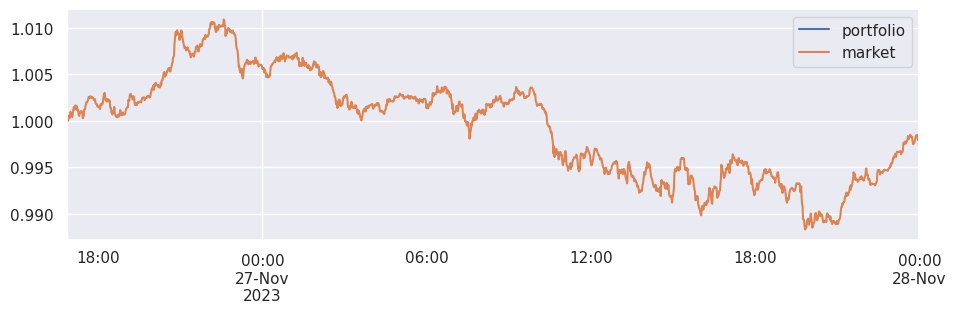

In [10]:
# env.py

import os
import numpy as np
import pandas as pd

EPS = 1e-8


class PortfolioEnv:
    """ This class creates the financial market environment that the Agent interact with.

    The observations include a history of the signals with the given `window_length` ending at the current date.

    Args:
        trading_cost (float):  Cost of trade as a fraction.
        window_length (int):  How many past observations to return.
        prices_name (str):  CSV file name for the price history.
        signals_name (str):  CSV file name for the signals.

    Attributes:
        dates (np.array of np.datetime64):  [n_days] Dates for the signals and price history arrays.
        n_signals (int):  Number of signals for each asset in each observation.
        n_signals_total (int):  Number of total signals in each observation.
        n_assets (int):  Number of assets in the price history.
        market_value (float):  The market value, starting at $1.
        portfolio_value (float):  The portfolio value, starting with $1 in cash.
        gain (np.array):  [n_days, n_assets] The relative price vector; tomorrow's / today's price.
        signals (np.array):  [1, n_signals_total, n_days]  Signals that define the observable environment.
        start_day (int):  The start date index in the signals and price arrays.
        step_number (int):  The step number of the episode.
        asset_names (list of str):  The stock tickers.
        trading_cost (float):  Cost of trade as a fraction.
        window_length (int):  How many past observations to return.
        weights (np.array):  [1 + n_assets]  The portfolio asset weighting starting with cash.
    """

    def __init__(self, trading_cost, window_length, prices_name, signals_name):
        """An environment for financial portfolio management."""

        # Initialize some local parameters
        self.market_value = 1.0
        self.portfolio_value = 1.0
        self.step_number = 0
        self.start_day = 0

        # Save some arguments as attributes
        self.trading_cost = trading_cost
        self.window_length = window_length

        # Read the stock data and convert to the relative price vector (gain)
        #   Note the raw prices have an extra day vs the signals to calculate gain

          #changed for colab
        #src_folder = os.path.split(os.path.dirname(__file__))[0]
        #raw_prices = pd.read_csv(os.path.join(src_folder, prices_name), index_col=0, parse_dates=True)
        raw_prices = pd.read_csv(prices_name, index_col=0, parse_dates=True)
        self.asset_names = raw_prices.columns.tolist()
        self.gain = np.hstack((np.ones((raw_prices.shape[0]-1, 1)), raw_prices.values[1:] / raw_prices.values[:-1]))
  #

  #
        self.dates = raw_prices.index.values
        self.n_dates = self.dates.shape[0] - 1
        self.n_assets = len(self.asset_names)
        self.weights = np.insert(np.zeros(self.n_assets), 0, 1.0)

        # Read the signals

          #changed for colab
        #df = pd.read_csv(os.path.join(src_folder, signals_name), index_col=0, parse_dates=True)
        df = pd.read_csv(signals_name, index_col=0, parse_dates=True)

        signal_names = [s.split("_", 1)[0] for s in df.columns if s.endswith('_' + self.asset_names[0])]
        columns = [s + '_' + a for s in signal_names for a in self.asset_names]
        self.signals = df.loc[:, columns].T.values[np.newaxis, :, :]
        self.n_signals = len(signal_names)
        self.n_signals_total = self.signals.shape[1]

          #Trial 1: Create numpy array to store each step and weights
        #steps_weights_arr = np.array([])
        #self.steps_weights_arr = np.array([])
        #self.add_steps_weights_arr = np.array([])
    # -----------------------------------------------------------------------------------
    def step(self, action):
        """Step the environment.

        Args:
            action (np.array):  The desired portfolio weights [w0...].

        Returns:
            np.array:  [batch_size, n_signals_total, window_length] The observation of the environment (state).
            float:  The reward received from the previous action.
        """

        t = self.start_day + self.step_number  # t is when you make the trade
        w0 = self.weights                      # w0 is the portfolio weights before trading
        p0 = self.portfolio_value              # p0 is the portfolio value before trading
        gain = self.gain[t]                    # gain is the relative price vector; tomorrow's / today's price.

        # Force the new weights (w1) to (0.0, 1.0) and sum weights = 1, note 1st weight is cash
        #   w0_post is the desired portfolio weighting after the trades but still at time t
        w0_post = np.clip(action, a_min=0, a_max=1)
        w0_post = np.insert(w0_post, 0, np.clip(1 - w0_post.sum(), a_min=0, a_max=1))
        w0_post = w0_post / w0_post.sum()

        # Calculate the loss due to trading costs
        loss = p0 * self.trading_cost * (np.abs(w0_post - w0)).sum()

        # Calculate the weights after the price evolution, w1 is the weights at t + 1
        w1 = (gain * w0_post) / (np.dot(gain, w0_post) + EPS)

        # Calculate the portfolio value at t + 1
        p1 = p0 * np.dot(gain, w0_post) - loss
        p1 = np.clip(p1, 0, np.inf)                         # Limit portfolio to zero (busted)
        reward = np.log((p1 + EPS) / (p0 + EPS))            # log rate of return

        # Save weights and portfolio value for next iteration
        self.weights = w1
        #print(f'weights adjusted: {self.weights}')
        self.portfolio_value = p1

        # Observe the new environment (state)
        t0 = t - self.window_length + 1
        state = self.signals[:, :, t0:t+1]

        # Save market value and increment the step number
        self.market_value *= gain.mean()
        self.step_number += 1

        #Trial 1: append t and weights
        #with np.printoptions(precision=3, suppress=False):
          #self.add_steps_weights_arr = np.array([np.append(t,w1)])
          #self.steps_weights_arr = np.append(self.steps_weights_arr, self.add_steps_weights_arr, axis=0)

        #print(f'added {add_steps_weights_arr}')

        return state, reward

    def reset(self, epoch_start, market_value=1.0, portfolio_value=1.0, weights=None):
        """Reset the environment to the initial state.

        Args:
            epoch_start (int):  The epoch start date index.
            market_value (float):  The market value.
            portfolio_value (float):  The portfolio value.
            weights (np.array):  [1 + n_assets]  The portfolio asset weighting starting with cash.

        Returns:
            np.array:  [n_signals_total * window_length] The first state observation
        """
          #Trail 1: print to view when the weights are reset
        #print('env reset')
        self.start_day = epoch_start
        if weights is None:
            self.weights = np.insert(np.zeros(self.n_assets), 0, 1.0)
          #Trail 1: print when weights are reset
            #print(f'weights reset {self.weights}')
            #with np.printoptions(precision=3, suppress=False):
              #self.add_steps_weights_arr = np.array([np.append(self.start_day, self.weights)])
              #self.steps_weights_arr = self.add_steps_weights_arr
              #print(f'reset array{self.steps_weights_arr}')
        else:
            self.weights = weights
        self.market_value = market_value
        self.portfolio_value = portfolio_value
        self.step_number = 0

        t = self.start_day + self.step_number

        t0 = t - self.window_length + 1

        state = self.signals[:, :, t0:t+1]

        return state

#-----------------------------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------------------------
# model.py

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as nn_f

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return -lim, lim


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, n_signals, window_length, n_assets, seed, fc1, fc2):
        """Initialize parameters and build model.

        Args:
            n_signals (int): Number of signals per asset
            window_length (int): Number of days in sliding window
            n_assets (int): Number of assets in portfolio not counting cash
            seed (int): Random seed
            fc1 (int):  Size of 1st hidden layer
            fc2 (int):  Size of 2nd hidden layer
        """

        super(Actor, self).__init__()

        self.n_signals = n_signals

        # TODO: This need to be removed per issue #3
        self.a1 = AssetModel(n_signals, window_length, seed, fc1, fc2)
        self.a2 = AssetModel(n_signals, window_length, seed, fc1, fc2)

        if fc2 == 0:
            self.fc_out = nn.Linear(fc1 * n_assets, n_assets)
        else:
            self.fc_out = nn.Linear(fc2 * n_assets, n_assets)
        self.reset_parameters()

        #print(f'this is assetModel a1 for actor: {self.a1}')

    def reset_parameters(self):

        # TODO: This need to be removed per issue #3
        self.a1.reset_parameters()
        self.a2.reset_parameters()

        self.fc_out.weight.data.uniform_(-3e-3, 3e-3)
        self.fc_out.bias.data.fill_(0.1)

    def forward(self, state):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""

        # TODO: This need to be removed per issue #3
        s1, s2 = torch.split(state, self.n_signals, 1)
        x1 = self.a1(s1)
        x2 = self.a2(s2)

        x = torch.cat((x1, x2), 1)

        return self.fc_out(x)


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, n_signals, window_length, n_assets, seed, fc1, fc2):
        """Initialize parameters and build model.

        Args:
            n_signals (int): Number of signals per asset
            window_length (int): Number of days in sliding window
            n_assets (int): Number of assets in portfolio not counting cash
            seed (int): Random seed
            fc1 (int):  Size of 1st hidden layer
            fc2 (int):  Size of 2nd hidden layer
        """

        super(Critic, self).__init__()
        self.n_signals = n_signals

        # TODO: This need to be removed per issue #3
        if n_assets != 2:
            print("ERROR:  Only operational to 10 assets per issue #3.")
            raise RuntimeError
        self.a1 = AssetModel(n_signals, window_length, seed, fc1, fc2)
        self.a2 = AssetModel(n_signals, window_length, seed, fc1, fc2)

        if fc2 == 0:
            self.fc_out = nn.Linear(fc1 * n_assets + n_assets, n_assets)
        else:
            self.fc_out = nn.Linear(fc2 * n_assets + n_assets, n_assets)
        self.reset_parameters()

        #print(f'this is assetModel a1 for critic: {self.a1}')

    def reset_parameters(self):

        # TODO: This need to be removed per issue #3
        self.a1.reset_parameters()
        self.a2.reset_parameters()

        self.fc_out.weight.data.uniform_(-3e-3, 3e-3)
        self.fc_out.bias.data.fill_(0.1)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""

        # TODO: This need to be removed per issue #3
        s1, s2 = torch.split(state, self.n_signals, 1)
        x1 = self.a1(s1)
        x2 = self.a2(s2)

        x = torch.cat((x1, x2, action), 1)

        return self.fc_out(x)


class AssetModel(nn.Module):
    def __init__(self, n_signals, window_length, seed, fc1, fc2):
        """Network built for each asset.

        Args:
            n_signals (int): Number of signals per asset
            window_length (int): Number of days in sliding window
            seed (int): Random seed
            fc1 (int):  Size of 1st hidden layer
            fc2 (int):  Size of 2nd hidden layer
        """
        super(AssetModel, self).__init__()
        out_channels = n_signals
        kernel_size = 3
        self.use_fc2 = fc2 > 0
        self.n_signals = n_signals

        self.conv1d_out = (window_length - kernel_size + 1) * out_channels
        self.seed = torch.manual_seed(seed)

        self.relu = nn.ReLU(inplace=True)
        self.drop1 = nn.Dropout(p=0.1)
        self.drop2 = nn.Dropout(p=0.2)

        self.conv1d = nn.Conv1d(n_signals, out_channels, kernel_size=kernel_size)
        self.bn = nn.BatchNorm1d(out_channels)

        self.fc1 = nn.Linear(self.conv1d_out, fc1)
        if self.use_fc2:
            self.fc2 = nn.Linear(fc1, fc2)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.conv1d.weight)
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc1.bias.data.fill_(0.1)
        if self.use_fc2:
            self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
            self.fc2.bias.data.fill_(0.1)

    def forward(self, state):
        # x = self.relu(self.bn(self.conv1d(state)))
        # x = self.drop1(self.relu(self.bn(self.conv1d(state))))
        # x = self.drop1(self.relu(self.conv1d(state)))
        x = self.relu(self.conv1d(state))
        x = x.contiguous().view(-1, self.conv1d_out)
        # x = self.drop2(self.relu(self.fc1(x)))
        x = self.relu(self.fc1(x))
        if self.use_fc2:
            x = self.drop2(self.relu(self.fc2(x)))
        return x

#-----------------------------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------------------------
# ddpg_agent.py

import numpy as np
import random
import copy
from collections import namedtuple, deque
#from drl.model import Actor, Critic
import torch
import torch.nn.functional as nn_f
import torch.optim as optimum

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Agent:
    """Interacts with and learns from the environment."""

    def __init__(self, n_signals, window_length, n_assets, random_seed, lr_actor, lr_critic, buffer_size,
                 batch_size, tau, gamma, sigma, theta, fc1, fc2):
        """Initialize an Agent object.

        Args:
            n_signals (int): Number of signals per asset
            window_length (int): Number of days in sliding window
            n_assets (int): Number of assets in portfolio not counting cash
            random_seed (int): random seed
            lr_actor (float): initial learning rate for actor
            lr_critic (float): initial learning rate for critic
            batch_size (int): mini batch size
            buffer_size (int): replay buffer size
            gamma (float): discount factor
            tau (float): soft update of target parameters
            sigma (float): OU Noise standard deviation
            theta (float): OU Noise theta gain
            fc1 (int):  Size of 1st hidden layer
            fc2 (int):  Size of 2nd hidden layer
        """
        self.n_signals = n_signals
        self.n_assets = n_assets
        self.seed = random.seed(random_seed)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(n_signals, window_length, n_assets, random_seed, fc1, fc2).to(device)
        self.actor_target = Actor(n_signals, window_length, n_assets, random_seed, fc1, fc2).to(device)
        self.actor_optimizer = optimum.Adam(self.actor_local.parameters(), lr=lr_actor)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(n_signals, window_length, n_assets, random_seed, fc1, fc2).to(device)
        self.critic_target = Critic(n_signals, window_length, n_assets, random_seed, fc1, fc2).to(device)
        self.critic_optimizer = optimum.Adam(self.critic_local.parameters(), lr=lr_critic)

        # Noise process
        self.noise = OUNoise(size=n_assets, seed=random_seed, sigma=sigma, theta=theta)

        # Replay memory
        self.memory = ReplayBuffer(n_assets, buffer_size, batch_size, random_seed)

    def step(self, state, actions, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, actions, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences)

    def act(self, state):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()
        self.actor_local.reset_parameters()
        self.actor_target.reset_parameters()
        self.critic_local.reset_parameters()
        self.critic_target.reset_parameters()

    def learn(self, experiences):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Args:
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
        """
        states, actions, rewards, next_states, done_values = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        q_targets = rewards + (self.gamma * q_targets_next * (1 - done_values))
        # Compute critic loss
        q_expected = self.critic_local(states, actions)
        critic_loss = nn_f.mse_loss(q_expected, q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, self.tau)
        self.soft_update(self.actor_local, self.actor_target, self.tau)

    @staticmethod
    def soft_update(local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)


class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, sigma, theta, mu=0.):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.state = copy.copy(self.mu)

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for _ in range(len(x))])
        self.state = x + dx
        return self.state


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, n_assets, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.n_assets = n_assets
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)

        next_states = np.vstack([e.next_state for e in experiences if e is not None])
        next_states = torch.from_numpy(next_states).float().to(device)

        done_values = np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)
        done_values = torch.from_numpy(done_values).float().to(device)

        return states, actions, rewards, next_states, done_values

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

#-----------------------------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------------------------
# train.py
import ast
import argparse
from collections import deque
import numpy as np
import os
import pandas as pd
import platform
#from drl.ddpg_agent import Agent
#from drl.env import PortfolioEnv
from time import time
import torch

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU activated.")
else:
    device = torch.device("cpu")
    print("CPU activated.")


# ***************************************************************************************
def make_plot(output_dir, start_day, show=False):
    """Makes a pretty training plot call score.png.

    Args:
        output_dir (str):  Location to save output.
        start_day (int):  Date index when trading began.
        show (bool):  If True, show the image.  If False, save the image.
    """

    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set()

    # Load the trading history
    # ---------------------------------------------------------------------------------------
    #history = pd.read_csv(os.path.join(output_dir, 'history.csv'), index_col=0)

    # Make a pretty plot
    # ---------------------------------------------------------------------------------------
    history.iloc[start_day-2:, :].plot(y=['portfolio', 'market'], use_index=True, figsize=(11, 3))
    if show:
        plt.show()
    else:
        plt.savefig(os.path.join(output_dir, 'history.png'), dpi=200)
    plt.close()

# ***************************************************************************************
def offline_training(day):
    """This function performs the offline.

    Args:
        day (int):  The date index that the training is being called from.
    """

    # The target alpha based on the annual target and 252 trading days
    target = (1.0 + arg_target) ** (arg_days_per_epoch/252.0)
    if arg_debug:
        print('Target = {}.'.format(target))

    # The minus 1 is critical to ensure the training does NOT get to see tomorrow's prices
    max_start_day = day - arg_days_per_epoch - 1

    # The start date of each epoch is selected randomly with the probability skewed
    #     exponentially toward today.
    p = np.exp(arg_memory_strength * np.arange(max_start_day) / max_start_day)
    p[:arg_window_length + 1] = 0
    p = p / p.sum()

    # We train until we consistently beat the market or the max number of epochs reached.
    epoch_window = deque(maxlen=10)        #originally 10
#
    historical_df = pd.DataFrame()
#
    for e in range(arg_max_epochs):
        state = env.reset(epoch_start=np.random.choice(max_start_day, size=None, p=p))

       # print(f'state begin: {state} :end state')

        for d in range(arg_days_per_epoch):
            actions = agent.act(state=state)
            next_state, reward = env.step(actions)

            agent.step(state, actions, reward, next_state, d == (arg_days_per_epoch - 1))
            state = next_state
        epoch_window.append(env.portfolio_value / env.market_value)

        if len(epoch_window) > 5:
            if np.mean(epoch_window) > target:
                break
            elif np.mean(epoch_window) < 0.9:
                epoch_window = deque(maxlen=10)        #originally 10
                agent.reset()
            elif arg_debug:
                print(np.mean(epoch_window))



# ***************************************************************************************
def train():
    """This function trains the given agent in the given environment."""

    start_time = time()

    # The target alpha based on the annual target and 5 trading days
    target = (1.0 + arg_target) ** (5.0/252.0) - 1.0

    # Perform the initial training
    # -----------------------------------------------------------------------------------
    print('Beginning initial training.')
    offline_training(arg_start_day)
    #print(f'out of offline training\n necessary alpha or retrain {target}')

    # Begin the daily trading and retraining if required
    # -----------------------------------------------------------------------------------
    portfolio = np.ones(env.n_dates + 1)
    market = np.ones(env.n_dates + 1)
    weights = np.insert(np.zeros(env.n_assets), 0, 1.0)
    add_steps_weights_arr = np.array([np.append(arg_start_day,weights)])
    steps_weights_arr = np.array(add_steps_weights_arr)
    delta_days = 5
    days_after_train = 0
    for day in range(arg_start_day, env.n_dates):
        days_after_train += 1

        # Make the real trade for today (you only get to do this once)
        state = env.reset(epoch_start=day, portfolio_value=portfolio[day], market_value=market[day], weights=weights)
        actions = agent.act(state=state)
        next_state, reward = env.step(actions)
        agent.step(state, actions, reward, next_state, done=True)

        # Save tomorrow's portfolio and market values
        portfolio[day + 1] = env.portfolio_value
        market[day + 1] = env.market_value
        weights = env.weights
        add_steps_weights_arr = np.array([np.append(day,weights)])
        steps_weights_arr = np.append(steps_weights_arr, add_steps_weights_arr, axis=0)
        alpha = (portfolio[day + 1] - portfolio[day - delta_days + 1]) / portfolio[day - delta_days + 1] - \
                (market[day + 1] - market[day - delta_days + 1]) / market[day - delta_days + 1]
        # Print some info to screen to color the drying paint
        if day % 10 == 0:
            print('Day {} p/m ratio: {:.2f}'.format(day, portfolio[day + 1] / market[day + 1]))
            #print(f'Day {day} p/m ratio: {portfolio[day + 1] / market[day + 1]:.2f}       | Alpha: {alpha:.4f} | Weights: [{add_steps_weights_arr[0][1]:.4f},{add_steps_weights_arr[0][2]:.4f}') #trial 1

        # Retrain if we aren't beating the market over last five days
        #alpha = (portfolio[day + 1] - portfolio[day - delta_days + 1]) / portfolio[day - delta_days + 1] - \
                #(market[day + 1] - market[day - delta_days + 1]) / market[day - delta_days + 1]
        if (alpha <= target) and (days_after_train > delta_days):
            print(f'Retraining') #Trial 1
            offline_training(day)
            days_after_train = 0

    # Print the final information for curiosity and hyperparameter tuning
    alpha = (1 + portfolio[-1] - market[-1]) ** (252.0 / (env.n_dates - arg_start_day)) - 1.0
    print('{:.2f} annualized alpha.'.format(alpha))
    duration = (time() - start_time)/60
    print('{:.2f} minutes of training.'.format(duration))

    # The objective will be minimized so there is a big penalty for missing the target
    objective = 100000 * np.max([0.0, arg_target - alpha])

    # Faster is better so there is a penalty for run time
    objective += duration

    # And a little boost for alpha above the target
    objective -= 1000 * np.max([0.0, alpha - arg_target])

    print('{:.2f} training objective.'.format(objective))

    # Save models weights and training history
    # -----------------------------------------------------------------------------------
    #for p in [p for p in [arg_model_dir, arg_output_dir] if not os.path.isdir(p)]:
    #    os.mkdir(p)
    #torch.save(agent.actor_target.state_dict(), os.path.join(arg_model_dir, 'checkpoint_actor.pth'))
    #torch.save(agent.critic_target.state_dict(), os.path.join(arg_model_dir, 'checkpoint_critic.pth'))
    history = pd.DataFrame(index=env.dates, data={'portfolio': portfolio, 'market': market})

    return(history)
    #history.to_csv(os.path.join(arg_output_dir, 'history.csv'))

import ast
import argparse
from collections import deque
import numpy as np
import os
import pandas as pd
import platform
#from drl.ddpg_agent import Agent
#from drl.env import PortfolioEnv
from time import time
import torch
#from google.colab import drive
#drive.mount('/content/drive')

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU activated.")
else:
    device = torch.device("cpu")
    print("CPU activated.")

if __name__ == '__main__':
  #steps_weights_arr = np.array([]) # Trial 1

# general setting
  arg_prices_name = 'price_df.csv'
  arg_signals_name = 'signals_df.csv'
  arg_trading_cost = 0.0025 #trading cost (default: 0.0025)
  arg_debug = 0

# hyperparameters than can be tuned
  arg_max_epochs = 2000 #max epochs per new trading day (default: 2000)
  arg_days_per_epoch = 40 #days in each epoch (default: 40)
  arg_start_day = 2420 #day to begin training (default: 504)
  arg_window_length = 10 #CNN window length (default: 10)
  arg_memory_strength = 2.0 #memorey exponential gain (default: 2.0)
  arg_target = 0.01 #target annual alpha (default: 0.05)
  arg_fc1 = 16 # size of 1st hidden layer (default: 13)
  arg_fc2 = 0 #size of 2nd hidden layer (default: 0)
  arg_lr_actor = 0.00092 #actor learning rate (default: 0.00039)
  arg_lr_critic = 0.00431 #critic learning rate (default: 0.0036)
  arg_batch_size = 256 # mini batch size (default: 256)
  arg_buffer_size = int(1e5) #replay buffer size (default: 10,000)
  arg_gamma = 0.91 #discount factor (default: 0.91)
  arg_tau = 0.0072 # soft update of target parameters (default:0.0072)
  arg_sigma = 0.0 #OU Noise standard deviation (default: 0.0)
  arg_theta = 0.0 #OU Noise theta gain (default: 0.0)

# originally retrieved from sagemaker
  arg_model_dir = "content/drive/MyDrive/DRL_Model"
#  arg_input_dir = ...
  arg_output_dir = "content/drive/My Drive/DRL_Model"
#    parser.add_argument('--model_dir', type=str, default=os.environ['SM_MODEL_DIR'],
#                        help='where the trained model should be saved')
#    parser.add_argument('--input_dir', type=str, default=os.environ['SM_INPUT_DIR'],
#                        help='where SageMaker will place the training data')
#    parser.add_argument('--output_dir', type=str, default=os.environ['SM_OUTPUT_DATA_DIR'],
#                        help='where miscellaneous files should be saved')

# setting up env
  print('Setting up the environment.')
  env = PortfolioEnv(prices_name=arg_prices_name, signals_name=arg_signals_name,
                       trading_cost=arg_trading_cost, window_length=arg_window_length)
  print('Number of assets: {}'.format(env.n_assets))
  print('Signals per asset: {}'.format(env.n_signals))
  # Create the reinforcement learning agent
    # -----------------------------------------------------------------------------------
  agent = Agent(n_assets=env.n_assets, n_signals=env.n_signals,
                  window_length=arg_window_length, lr_actor=arg_lr_actor, lr_critic=arg_lr_critic,
                  batch_size=arg_batch_size, buffer_size=arg_buffer_size, gamma=arg_gamma, tau=arg_tau,
                  sigma=arg_sigma, theta=arg_theta, fc1=arg_fc1, fc2=arg_fc2, random_seed=42)
   # Perform the training
    # -----------------------------------------------------------------------------------
  print('Training the agent.')
  start = time()
  history = train()
  history
  print("Training Time:  {:.1f} minutes".format((time() - start)/60.0))

  # Make some pretty plots
    # -----------------------------------------------------------------------------------
  print('Make training plot.')
  make_plot(output_dir=arg_output_dir, start_day=arg_start_day, show=True)
